In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np  
import pandas as pd 
import re           
from keras.preprocessing.text import Tokenizer 
from bs4 import BeautifulSoup 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Attention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import nltk
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [9]:
data=pd.read_csv("/content/drive/MyDrive/Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [10]:
data.drop_duplicates(subset=['Text'],inplace=True)  
data.dropna(axis=0,inplace=True) 

In [11]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

# Preprocessing

- converting to lower case
- removing html tags
- applying contraction mapping
- remove spl characters and stopwords
- removing short words

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [14]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [15]:
# adding start and end tokens
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [16]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

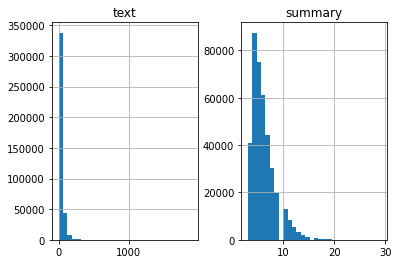

In [17]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

As we need to tokenize and pad the text therefore we need a max length for text and summary 

In [18]:
from sklearn.model_selection import train_test_split
max_text=80 
max_summary=10
x_train, x_val, y_train, y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.15,random_state=0,shuffle=True) 

In [19]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_train    =   x_tokenizer.texts_to_sequences(x_train) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

x_train    =   pad_sequences(x_train,  maxlen=max_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [20]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_train    =   y_tokenizer.texts_to_sequences(y_train) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

y_train    =   pad_sequences(y_train, maxlen=max_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [21]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_out = Attention()([decoder_outputs,encoder_outputs]) 

# decoder_outputs = GlobalAveragePooling1D()(decoder_outputs)
# attn_out = GlobalAveragePooling1D()(attn_out)

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      55601500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [23]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
653/653 [==============================] - 1144s 2s/step - loss: 2.7698 - val_loss: 2.3043
Epoch 2/10
653/653 [==============================] - 1130s 2s/step - loss: 2.2748 - val_loss: 2.1251
Epoch 3/10
653/653 [==============================] - 1131s 2s/step - loss: 2.1002 - val_loss: 2.0561
Epoch 4/10
653/653 [==============================] - 1130s 2s/step - loss: 1.9978 - val_loss: 2.0147
Epoch 5/10
653/653 [==============================] - 1145s 2s/step - loss: 1.9183 - val_loss: 1.9871
Epoch 6/10
653/653 [==============================] - 1148s 2s/step - loss: 1.8411 - val_loss: 1.9726
Epoch 7/10
653/653 [==============================] - 1148s 2s/step - loss: 1.7781 - val_loss: 1.9709
Epoch 8/10
653/653 [==============================] - 1147s 2s/step - loss: 1.7199 - val_loss: 1.9752
Epoch 00008: early stopping


In [24]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [48]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf = Attention()([decoder_outputs2,decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],[decoder_outputs2] + [state_h2, state_c2])

In [65]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # print(sampled_token_index)
        if sampled_token_index==2 : break
        else: sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [66]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [67]:
i=1
print("Review:",seq2text(x_val[i]))
print("Original summary:",seq2summary(y_val[i]))
print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text)))
print("\n")

Review: whenever want add bit cream soup sauce never seem around use cream often enough even buy smallest container stuff kept long time really add creamy flavor glad found 
Original summary: this stuff is great 
Predicted summary:  love this stuff




In [70]:
for i in range(10):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text)))
  print("\n")

Review: love hot sauces rediculous thought like good hot sauce would good tacos nachos etc nice heat stuff stupid hot bought three pack regreted moment tried standard insanity sauce cannot even tolerate dashes tacos good 
Original summary: seriously 
Predicted summary:  good hot sauce


Review: whenever want add bit cream soup sauce never seem around use cream often enough even buy smallest container stuff kept long time really add creamy flavor glad found 
Original summary: this stuff is great 
Predicted summary:  love this stuff


Review: glad opportunity purchase last boxes amazing tea local herb stores tell sold anymore cannot sold unless ground powder form hope buy overseas batch runs 
Original summary: last of the best 
Predicted summary:  love this tea


Review: tried peanut butter creme version first impression fudge coating looker rather soft would messy left warm day tasting overwhelming sweetness predominant aside sweetness flavor butterfinger reeses slight crunchiness cooki

# TESTING

In [ ]:
inptext= ""
cleaned_inp = []
cleaned_inp.append(text_cleaner(inptext))
inp = x_tokenizer.texts_to_sequences(cleaned_inp) 
inp = pad_sequences(inp,  maxlen=max_text, padding='post') 
print(decode_sequence(inp.reshape(1,max_text)))
